# Packages

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import shapely.speedups
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
from shapely.ops import nearest_points

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Geospatial Analysis\\Automating GIS Processes'

# Point in Polygon & Intersect

Finding out if a certain point is located inside or outside of an area, or finding out if a line intersects with another line or polygon are fundamental geospatial operations that are often used e.g. to select data based on location. Such spatial queries are one of the typical first steps of the workflow when doing spatial analysis. Performing a spatial join (will be introduced later) between two spatial datasets is one of the most typical applications where Point in Polygon (PIP) query is used.

## How to check if point is inside a polygon?

Computationally, detecting if a point is inside a polygon is most commonly done using a specific formula called **Ray Casting algorithm**. Luckily, we do not need to create such a function ourselves for conducting the Point in Polygon (PIP) query. Instead, we can take advantage of Shapely’s binary predicates that can evaluate the topolocical relationships between geographical objects, such as the PIP as we’re interested here.

There are basically two ways of conducting PIP in Shapely:
1. Using a function called `.within()` that checks if a point is within a polygon
2. Using a function called `.contains()` that checks if a polygon contains a point

Notice: even though we are talking here about Point in Polygon operation, it is also possible to check if a LineString or Polygon is inside another Polygon.

In [35]:
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

print(p1)
print(p2)
print(poly)

POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


In [36]:
print("P1 is within Polygon: ", p1.within(poly))
print('P2 is within Polygon: ', p2.within(poly))

P1 is within Polygon:  True
P2 is within Polygon:  False


In [37]:
print(poly.centroid)

POINT (24.952242428492358 60.16960179038188)


In [38]:
# The other way around
print("Polygon contains P1: ", poly.contains(p1))
print('Polygon contains P2: ', poly.contains(p2))

Polygon contains P1:  True
Polygon contains P2:  False


Thus, both ways of checking the spatial relationship results in the same way.

Which one should you use then? Well, it depends:
- If you have many points and just one polygon and you try to find out which one of them is inside the polygon:
    - You need to iterate over the points and check one at a time if it is `within()` the polygon specified
- If you have many polygons and just one point and you want to find out which polygon contains the point
    - You need to iterate over the polygons until you find a polygon that `contains()` the point specified (assuming there are no overlapping polygons)

## Intersect

Another typical geospatial operation is to see if a geometry intersect or touches another one. The difference between these two is that:
- If objects **intersect**, the boundary and interior of an object needs to intersect in any way with those of the other.
- If an object touches the other one, it is only necessary to have (at least) a single point of their boundaries in common but their interiors shoud NOT intersect.

In [39]:
# Create twolines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])

print('Line A intersects Line B: ', line_a.intersects(line_b))
print('Line A touches Line B: ', line_a.touches(line_b))

Line A intersects Line B:  True
Line A touches Line B:  True


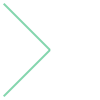

In [40]:
# Verify by plotting features together
multi_line = MultiLineString([line_a, line_b])
multi_line

In [41]:
# Does the line touch itself?
print('Line A touches Line A: ', line_a.touches(line_a))

# Does the line intersect with itself?
print('Line A intersects Line A: ', line_a.intersects(line_a))

Line A touches Line A:  False
Line A intersects Line A:  True


Next we will do a practical example where we check which of the addresses from previous tutorial are located in Southern district of Helsinki. We will use a KML-file that has the Polygons for districts of Helsinki Region (data openly available from Helsinki Region Infoshare.

In [42]:
fp = 'data/L4/L4_data/addresses.shp'
data = gpd.read_file(fp)
data.head()

,address,id,geometry
0,"Kampinkuja 1, 00100 Helsinki, Finland",1001,POINT (24.93017 60.16837)
1,"Kaivokatu 8, 00101 Helsinki, Finland",1002,POINT (24.94189 60.16987)
2,"Hermanstads strandsväg 1, 00580 Helsingfors, F...",1003,POINT (24.97740 60.18736)
3,"Itäväylä, 00900 Helsinki, Finland",1004,POINT (25.09196 60.21448)
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",1005,POINT (24.92148 60.15658)


## Reading KML-files in Geopandas

It is possible to read the data from KML-file in a similar manner as Shapefile. However, we need to first, enable the KML-driver which is not enabled by default (because KML-files can contain unsupported data structures, nested folders etc., hence be careful when reading KML-files).

Let’s enable the read and write functionalities for KML-driver by passing `'rw'` to whitelist of fiona’s supported drivers:

In [43]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

fp = 'data/L4/L4_data/PKS_suuralue.kml'
polys = gpd.read_file(fp, driver = 'KML')
polys

,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."
5,Kauniainen,,"POLYGON Z ((24.69075 60.21958 0.00000, 24.6924..."
6,Suur-Leppävaara,,"POLYGON Z ((24.79747 60.20827 0.00000, 24.7954..."
7,Suur-Tapiola,,"POLYGON Z ((24.84436 60.16598 0.00000, 24.8443..."
8,Myyrmäki,,"POLYGON Z ((24.82459 60.29025 0.00000, 24.8243..."
9,Kivistö,,"POLYGON Z ((24.94309 60.33845 0.00000, 24.9421..."


Nice, now we can see that we have 22 districts in our area. We are interested in an area that is called `Eteläinen` (‘Southern’ in english).

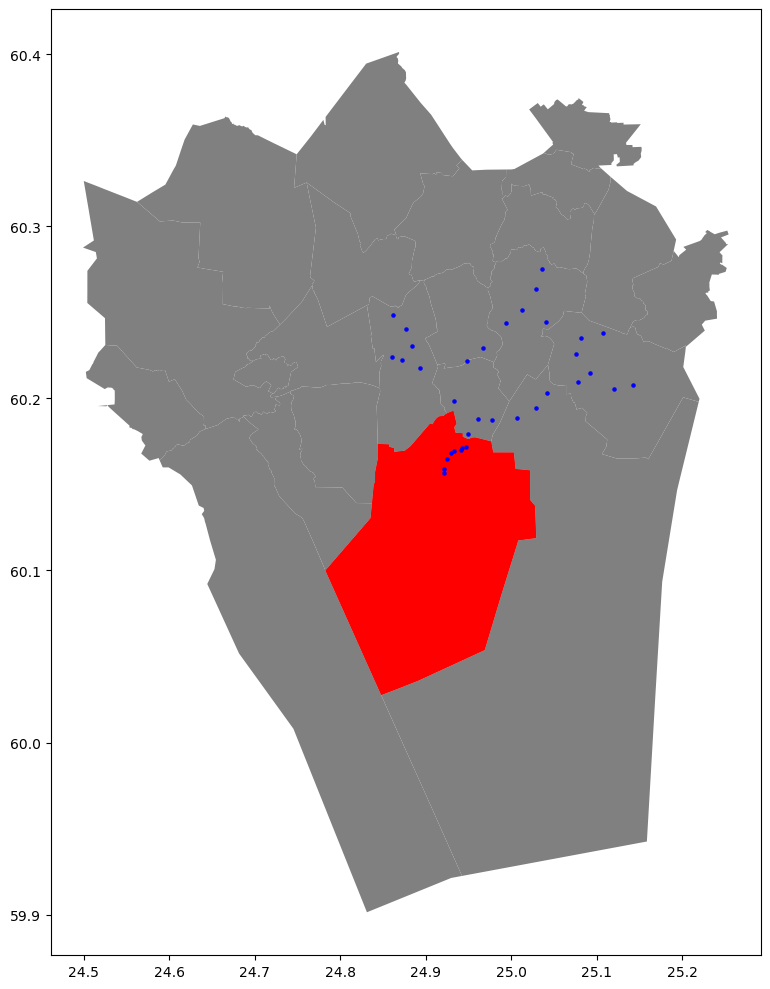

In [44]:
# Select 'Etelainen' district (Southern)
southern = polys.loc[polys['Name'] == 'Eteläinen']
southern.reset_index(drop = True, inplace = True)

# Create plot
fig, ax = plt.subplots(figsize = (10, 10))
polys.plot(facecolor = 'gray', ax = ax)
southern.plot(ax = ax, facecolor = 'red')
data.plot(ax = ax, color = 'blue', markersize = 5)
plt.tight_layout()
plt.show()

Let’s find out which one of them are located within the Polygon. Hence, we are conducting a Point in Polygon query.

Let’s first enable shapely.speedups which makes some of the spatial queries running faster. Then let’s check which Points are within the `southern` Polygon. Notice, that here we check if the Points are within the **geometry** of the `southern` GeoDataFrame. Hence, we use the `loc[0, 'geometry']` to parse the actual Polygon geometry object from the GeoDataFrame.

In [45]:
# Create a mask
pip_mask = data.within(southern.loc[0, 'geometry'])
pip_mask

0      True
1      True
2     False
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
34    False
dtype: bool

As we can see, we now have an array of boolean values for each row, where the result is `True` if Point was inside the Polygon, and `False` if it was not.

We can now use this mask array to select the Points that are inside the Polygon. Selecting data with this kind of mask array (of boolean values) is easy by passing the array inside the `loc` indexing function of Pandas.

In [46]:
# Select points that are within Polygon
pip_data = data.loc[pip_mask]
pip_data

,address,id,geometry
0,"Kampinkuja 1, 00100 Helsinki, Finland",1001,POINT (24.93017 60.16837)
1,"Kaivokatu 8, 00101 Helsinki, Finland",1002,POINT (24.94189 60.16987)
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",1005,POINT (24.92148 60.15658)
10,"Rautatientori 1, 00100 Helsinki, Finland",1011,POINT (24.94251 60.17119)
30,"Urho Kekkosen katu 1, 00100 Helsinki, Finland",1031,POINT (24.93376 60.16948)
31,"Gräsviksgatan 17, 00101 Helsingfors, Finland",1032,POINT (24.92501 60.16500)
32,"Stillahavsgatan 3, 00220 Helsingfors, Finland",1033,POINT (24.92140 60.15907)
33,"Vilhelmsgatan 4, 00101 Helsingfors, Finland",1034,POINT (24.94685 60.17191)


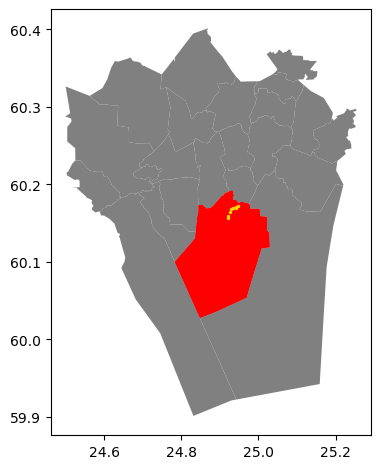

In [47]:
ax = polys.plot(facecolor = 'gray')
southern.plot(ax = ax, facecolor = 'red')
pip_data.plot(ax = ax, color = 'gold', markersize = 2)
plt.tight_layout()
plt.show()

# Spatial Join

Spatial join is yet another classic GIS problem. Getting attributes from one layer and transferring them into another layer based on their spatial relationship is something you most likely need to do on a regular basis.

The previous materials focused on learning how to perform a Point in Polygon query. We could now apply those techniques and create our own function to perform a spatial join between two layers based on their spatial relationship. We could for example join the attributes of a polygon layer into a point layer where each point would get the attributes of a polygon that `contains` the point.

Luckily, spatial join is already implemented in Geopandas, thus we do not need to create it ourselves. There are three possible types of join that can be applied in spatial join that are determined with `op`-parameter in the `gpd.sjoin()`-function:
- `"intersects"`
- `"within"`
- `"contains"`

Sounds familiar? Yep, all of those spatial relationships were discussed in the previous materials, thus you should know how they work. Let’s perform a spatial join between these two layers:
- **Addresses**: the address-point Shapefile that we created and reprojected previously
- **Population grid**: a Polygon layer that is a 250m x 250m grid showing the amount of people living in the Helsinki Region.

## Clean the data

In [48]:
# Filepath
fp = 'data/L4/L4_data/Vaestotietoruudukko_2015.shp'

# Read the data
pop = gpd.read_file(fp)
pop.head()

,INDEX,ASUKKAITA,ASVALJYYS,IKA0_9,IKA10_19,IKA20_29,IKA30_39,IKA40_49,IKA50_59,IKA60_69,IKA70_79,IKA_YLI80,geometry
0,688,8,31.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,703,6,42.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,710,8,44.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,711,7,64.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,715,19,23.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


So we have multiple columns in the dataset but the most important one here is the column `ASUKKAITA` (*population in Finnish*) that tells the amount of inhabitants living under that polygon.

Let’s change the name of that columns into `pop15` so that it is more intuitive. Changing column names is easy in Pandas / Geopandas using a function called `rename()` where we pass a dictionary to a parameter `columns = {'oldname': 'newname'}`. Let’s also get rid of all unnecessary columns by selecting only columns that we need i.e. `pop15` and `geometry`.

In [49]:
# Change the name of a column
pop = pop.rename(columns = {'ASUKKAITA': 'pop15'})
pop.columns

Index(['INDEX', 'pop15', 'ASVALJYYS', 'IKA0_9', 'IKA10_19', 'IKA20_29',
       'IKA30_39', 'IKA40_49', 'IKA50_59', 'IKA60_69', 'IKA70_79', 'IKA_YLI80',
       'geometry'],
      dtype='object')

In [50]:
selected_cols = ['pop15', 'geometry']
pop = pop[selected_cols]
pop.head()

,pop15,geometry
0,8,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,6,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,7,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,19,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


## Join the layers

Now we are ready to perform the spatial join between the two layers that we have. The aim here is to get information about **how many people live in a polygon that contains an individual address-point**. Thus, we want to join attributes from the population layer we just modified into the addresses point layer `addresses_epsg3879.shp`.

In [51]:
# Addresses filepath
addr_fp = 'data/L4/L4_data/addresses.shp'

# Read data
addresses = gpd.read_file(addr_fp)
addresses.head()

,address,id,geometry
0,"Kampinkuja 1, 00100 Helsinki, Finland",1001,POINT (24.93017 60.16837)
1,"Kaivokatu 8, 00101 Helsinki, Finland",1002,POINT (24.94189 60.16987)
2,"Hermanstads strandsväg 1, 00580 Helsingfors, F...",1003,POINT (24.97740 60.18736)
3,"Itäväylä, 00900 Helsinki, Finland",1004,POINT (25.09196 60.21448)
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",1005,POINT (24.92148 60.15658)


In [52]:
# Do they match?
addresses.crs == pop.crs

False

In [53]:
# Reproject addresses to the projection of the population layer
addresses = addresses.to_crs(pop.crs)

print(addresses.crs)
print(pop.crs)

addresses.crs == pop.crs

PROJCS["ETRS89_ETRS_GK25FIN_2010",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["Geodetic_Reference_System_of_1980",6378137,298.257222100892],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",25],PARAMETER["scale_factor",1],PARAMETER["false_easting",25500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["ETRS89_ETRS_GK25FIN_2010",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["Geodetic_Reference_System_of_1980",6378137,298.257222100892],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",25],PARAMETER["scale_factor",1],PARAMETER["false_easting",25500000],PARAMETER["false_northing",0],UNIT["metre",1

True

Indeed they are identical. Thus, we can be sure that when doing spatial queries between layers the locations match and we get the right results e.g. from the spatial join that we are conducting here.

Let’s now join the attributes from `pop` GeoDataFrame into `addresses` GeoDataFrame by using `gpd.sjoin()` function.

In [54]:
# Make a spatial join
join = gpd.sjoin(addresses, pop, how = 'inner', op = 'within')
join.head()

c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,address,id,geometry,index_right,pop15
0,"Kampinkuja 1, 00100 Helsinki, Finland",1001,POINT (25496123.309 6672833.942),3326,173
1,"Kaivokatu 8, 00101 Helsinki, Finland",1002,POINT (25496774.282 6672999.699),3449,31
10,"Rautatientori 1, 00100 Helsinki, Finland",1011,POINT (25496808.646 6673146.837),3449,31
3,"Itäväylä, 00900 Helsinki, Finland",1004,POINT (25505098.343 6677972.568),5112,353
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",1005,POINT (25495639.560 6671520.343),3259,1397


In [55]:
outfp = 'data/L4/L4_data/addresses_pop15_epsg3979.shp'
join.to_file(outfp)

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_27868\1809799118.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  join.to_file(outfp)


Plot the points and use the `pop15` column to indicate the color. `cmap` parameter tells to use a sequential colormap for the values, `markersize` adjusts the size of a point, `scheme` parameter can be used to adjust the classification method based on `pysal` <http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html>_, and `legend` tells that we want to have a legend.

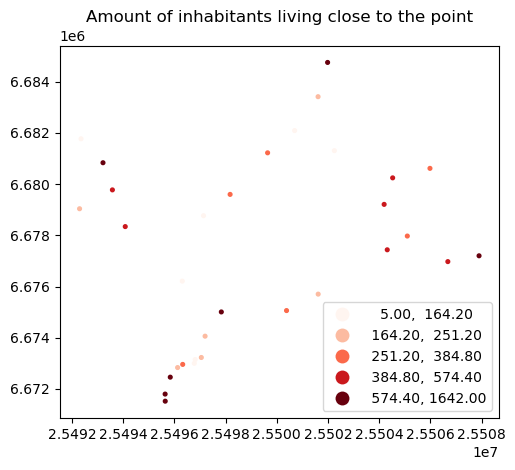

In [56]:
join.plot(column = 'pop15', cmap = 'Reds', markersize = 7, scheme = 'quantiles', legend = True)
plt.title('Amount of inhabitants living close to the point')
plt.tight_layout()

# Nearest Neighbor Analysis

One commonly used GIS task is to be able to find the nearest neighbour. For instance, you might have a single Point object representing your home location, and then another set of locations representing e.g. public transport stops. Then, quite typical question is *“which of the stops is closest one to my home?”*. This is a typical nearest neighbour analysis, where the aim is to find the closest geometry to another geometry.

In Python this kind of analysis can be done with shapely function called `nearest_points()` that returns a tuple of the nearest points in the input geometries.

## Nearest point using Shapely

Let’s start by testing how we can find the nearest Point using the `nearest_points()` function of Shapely.

Let’s create an origin Point and a few destination Points and find out the closest destination.

In [57]:
orig = Point(1, 1.67)
dest1, dest2, dest3 = Point(0, 1.45), Point(2, 2), Point(0, 2.5)

destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


In [58]:
nearest_geoms = nearest_points(orig, destinations)
near_idx0 = nearest_geoms[0]
near_idx1 = nearest_geoms[1]
print(nearest_geoms)
print(near_idx0)
print(near_idx1)

(<shapely.geometry.point.Point object at 0x000001E1BFD1C1D0>, <shapely.geometry.point.Point object at 0x000001E1C02D4F10>)
POINT (1 1.67)
POINT (0 1.45)


As you can see the `nearest_points()` function returns a tuple of geometries where the first item is the geometry of our origin point and the second item (at index 1) is the actual nearest geometry from the destination points. Hence, the closest destination point seems to be the one located at coordinates (0, 1.45).

This is the basic logic how we can find the nearest point from a set of points.

## Nearest points using Geopandas

Of course, the previous example is not really useful yet. Hence, next I show, how it is possible to find nearest points from a set of origin points to a set of destination points using GeoDataFrames.

In [65]:
def nearest(row, geom_union, df1, df2, geom1_col = 'geometry', geom2_col = 'geometry', src_column = None):
    '''Find the nearest point and return the corresponding value from the specified column.'''

    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]

    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].to_numpy()[0]

    return value

In [60]:
# Define filepaths
fp1 = 'data/L4/L4_data/PKS_suuralue.kml'
fp2 = 'data/L4/L4_data/addresses.shp'

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Read in data with geopandas
df1 = gpd.read_file(fp1, driver = 'KML')
df2 = gpd.read_file(fp2)

# Create unary union from Points, which creates a MultiPoint object
unary_union = df2.unary_union
print(unary_union)

MULTIPOINT (24.8609335 60.22401389999999, 24.86186 60.2485471, 24.8718598 60.22243630000001, 24.877383 60.240163, 24.8840504 60.2306474, 24.893153 60.2177823, 24.9214046 60.159069, 24.9214846 60.1565781, 24.9250072 60.16500139999999, 24.9301701 60.1683731, 24.9334051 60.1986856, 24.9337569 60.1694809, 24.9418933 60.1698665, 24.94251 60.1711874, 24.9468514 60.1719108, 24.9483202 60.22163339999999, 24.9494874 60.1793862, 24.9609122 60.18789030000001, 24.9670533 60.2291135, 24.9774004 60.18735880000001, 24.9934979 60.2436961, 25.0068399 60.18837519999999, 25.0125655 60.25149829999999, 25.0291078 60.2633799, 25.0291263 60.19413939999999, 25.035855 60.2753891, 25.040583 60.24444239999999, 25.042239 60.2033879, 25.0756547 60.225599, 25.0778094 60.20966609999999, 25.0816923 60.23489060000001, 25.0919641 60.21448089999999, 25.1080054 60.2382054, 25.1204966 60.20548979999999, 25.1424936 60.20751019999999)


In [61]:
df1['centroid'] = df1.centroid
df1.head()

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_27868\3029386028.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df1['centroid'] = df1.centroid


,Name,Description,geometry,centroid
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766...",POINT (24.76754 60.04409)
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155...",POINT (24.57415 60.19764)
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752...",POINT (24.60401 60.25253)
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699...",POINT (24.68683 60.30649)
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537...",POINT (24.76064 60.15018)


In [66]:
# Find the closest Points from df2 to df1 centroids
df1['nearest_id'] = df1.apply(nearest, geom_union = unary_union, df1 = df1, df2 = df2, geom1_col = 'centroid', src_column = 'id', axis = 1)
df1.head()

,Name,Description,geometry,centroid,nearest_id
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766...",POINT (24.76754 60.04409),1005
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155...",POINT (24.57415 60.19764),1020
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752...",POINT (24.60401 60.25253),1017
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699...",POINT (24.68683 60.30649),1017
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537...",POINT (24.76064 60.15018),1020
